In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt 
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import warnings
warnings.simplefilter('ignore')
rs = 11319 #random state

_Задача:_ спрогнозировать, будет ли возвращен велосипед на исходную станцию в конце поездки.

_Зачем?_ Может быть полезно при обслуживании станций, определении необходимого количества велосипедов для ее пополнения, организации работы оператора, определении необходимой численности парка по станциям.

## Часть 1. Предварительная подготовка датасета

### 1.1. Описание датасета

In [2]:
df = pd.read_csv('./bike.csv', parse_dates=[2, 3])

Датасет взят с сайта Kaggle https://www.kaggle.com/cityofLA/los-angeles-metro-bike-share-trip-data. Первоисточником является https://bikeshare.metro.net/about/data/, под управлением администрации ЛА (датасет обновляется ежемесячно по мере публикации отчетности оператором).
Каждая запись датасета описывает конкретную поездку и содрежит данные о
* времени начала и конца поздки (datetime);
* станции начала и конца поездки (номер станции + координаты: численные);
* уникальный номер велосипеда (численная);
* __тип поездки: оборотная или в одну сторону__ (категориальная);
* данные о подписке пользователя (категориальная).

На настоящий момент датасет содержит порядка 132 тыс. записей и 16 переменных. 

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132427 entries, 0 to 132426
Data columns (total 16 columns):
Trip ID                       132427 non-null int64
Duration                      132427 non-null int64
Start Time                    132427 non-null datetime64[ns]
End Time                      132427 non-null datetime64[ns]
Starting Station ID           132408 non-null float64
Starting Station Latitude     132379 non-null float64
Starting Station Longitude    132379 non-null float64
Ending Station ID             132331 non-null float64
Ending Station Latitude       131376 non-null float64
Ending Station Longitude      131376 non-null float64
Bike ID                       132417 non-null float64
Plan Duration                 131661 non-null float64
Trip Route Category           132427 non-null object
Passholder Type               132427 non-null object
Starting Lat-Long             98622 non-null object
Ending Lat-Long               131376 non-null object
dtypes: datetime64[n

### 1.2. Определение несущественных параметров

Удалим некоторые из переменных:
* Bike ID - не несет информации,
* Plan Duration - дублирует Passholder Type,
* Starting Lat-Long, Ending Lat-Long - дублируют координаты станций.


Переменные 
* End Time
* Duration

неизвестны на момент начала поездки.

Переменные 

* Ending Station  ID, Latitude, Longitude

также неизвестны на момент начала поездки, но понадобятся для определения параметров станций.


In [4]:
df = df.drop(['Starting Lat-Long',
              'Ending Lat-Long',
              'Bike ID',
              'Plan Duration',
              'End Time',
              'Duration'], axis=1)

Сбросим строки с пустыми значениями.

In [5]:
df = df.dropna()

### 1.3. Внедрение новых параметров

Интуитивно, тип поездки будет зависеть от ее цели. Например, едет человек на работу или отдыхать. Это, в свою очередь, будет коррелировать со временем и местом начала поздки. Попытаемся сгенерировать новые переменные на основании Starting Station и Start Time

#### 1.3.1. Время поездки

Разложим время начала и проверим, как сооотносится тип поездки с месяцем/днем недели/часом

In [6]:
df['Start Month'] = df['Start Time'].dt.month
df['Start Day'] = df['Start Time'].dt.weekday
df['Start Hour'] = df['Start Time'].dt.hour

Выведем доли оборотных поездок по часам/дням/месяцам.

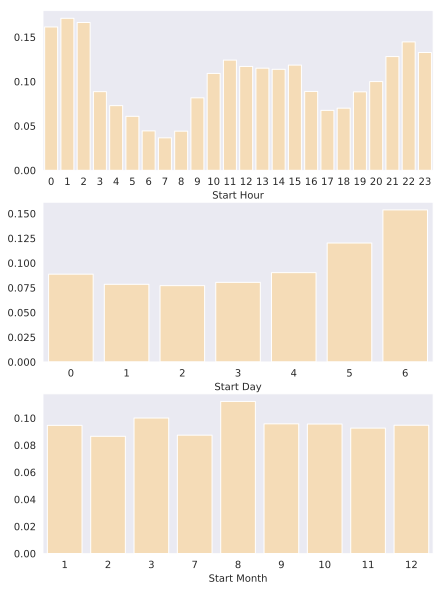

In [7]:
df_rt = df[df['Trip Route Category'] == 'Round Trip']
rt_prop_1= df_rt.groupby('Start Hour')['Trip ID'].count()/df.groupby('Start Hour')['Trip ID'].count()
rt_prop_2 = df_rt.groupby('Start Day')['Trip ID'].count()/df.groupby('Start Day')['Trip ID'].count()
rt_prop_3 = df_rt.groupby('Start Month')['Trip ID'].count()/df.groupby('Start Month')['Trip ID'].count()
sns.set_style('dark')
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(7, 10))
sns.barplot(rt_prop_1.index, rt_prop_1.values,
           ax=ax[0], color='navajowhite');
sns.barplot(rt_prop_2.index, rt_prop_2.values,
           ax=ax[1], color='navajowhite');
sns.barplot(rt_prop_3.index, rt_prop_3.values,
           ax=ax[2], color='navajowhite');


Из приведенных графиков становится ясно, что доля круговых поездок увеличивается:

1. Вне часов пик
* На выходных 
* В августе

Составим фичез, отвечающие этим закономерностям для выходных и часов пик:

In [8]:
df['Weekend'] = df['Start Day'] > 4
df['Rush'] = ((df['Start Hour'] > 15) & (df['Start Hour'] < 21)) | ((df['Start Hour'] > 3) & (df['Start Hour'] < 10))


#### 1.3.2. Стартовая станция

Уберем из рассмортения станции, расположенные аномально далеко

In [9]:
df = df[(df['Starting Station Latitude'] > 34) & (df['Starting Station Longitude'] < -118) & (df['Starting Station Longitude'] > -118.35)] 

Создадим отельный датафрейм со статистикой по станциям. В нем соберем информацию:
    
* о их местоположении,
* о количестве исходящих круговых поездок и поездок в оба конца,
* о количестве входящих круговых поездок и поездок в оба конца,
* о количестве исходящих и входящих поездок,
* об удалении от центра,

отдельной станции за всю историю ее эксплуатации, то есть попытаемся выявить потенциально "оборотные" станции старта.

In [10]:
stations = df.groupby('Starting Station ID')['Starting Station Latitude', 'Starting Station Longitude'].mean()
stations['RT Out'] = df[df['Trip Route Category'] == 'Round Trip'].groupby('Starting Station ID')['Trip Route Category'].count()
stations['OW Out'] = df[df['Trip Route Category'] == 'One Way'].groupby('Starting Station ID')['Trip Route Category'].count()
stations['RT In'] = df[df['Trip Route Category'] == 'Round Trip'].groupby('Ending Station ID')['Trip Route Category'].count()
stations['OW In'] = df[df['Trip Route Category'] == 'One Way'].groupby('Ending Station ID')['Trip Route Category'].count()
stations['Out'] = df.groupby('Starting Station ID')['Starting Station ID'].count()
stations['In'] = df.groupby('Ending Station ID')['Ending Station ID'].count()
stations['Ratio Out'] = stations['RT Out']/stations['OW Out']
stations['Ratio In'] = stations['RT In']/stations['OW In']
stations['Ratio OI'] = stations['Out']/stations['In']

x_mean = stations['Starting Station Longitude'].mean()
y_mean = stations['Starting Station Latitude'].mean()
stations['Radius'] = ((stations['Starting Station Latitude'] - y_mean)**2 +
                     (stations['Starting Station Longitude'] - x_mean)**2)**0.5

Рассмотрим географическое расположение станций аренды.

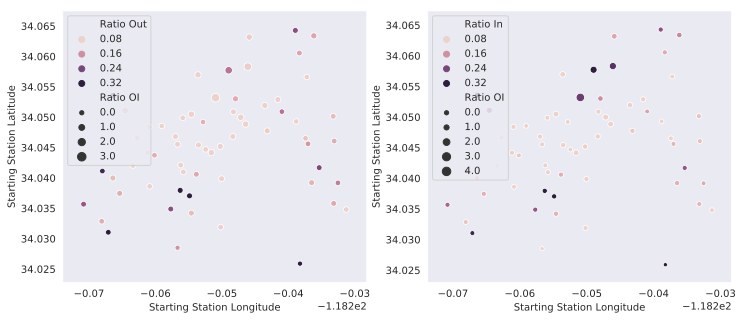

In [11]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
sns.scatterplot(y='Starting Station Latitude',
                x='Starting Station Longitude',
                hue='Ratio Out',
                hue_norm=(0.1, 0.3, 0.6),
                data=stations,
                ax=ax[0],
                size='Ratio OI',
                size_norm=(0.1, 3, 4))
sns.scatterplot(y='Starting Station Latitude',
                x='Starting Station Longitude',
                hue_norm=(0.1, 0.3, 0.6),
                hue='Ratio In',
                data=stations,
                ax=ax[1],
                size='Ratio OI')

Подготовим датасет по станциям для импорта на Гугл-мэпс.

In [12]:
stations_goog = stations[['Starting Station Latitude', 'Starting Station Longitude']]
stations_goog.to_csv('./LABikes.csv')

Получаем следующую карту:

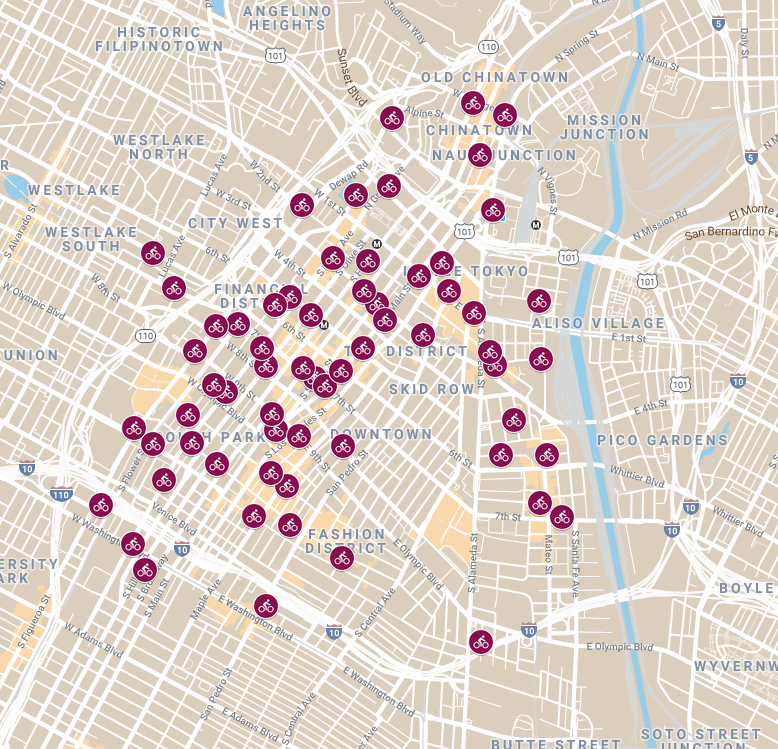

Сопоставив точки на карте города и созданные карты отношения числа поездок можно отметить:

* в целом, расположение станций приурочено к местам с высокой посещаемостью по данным гугл;
* станции с дисбалансом по "исходящим" поездкам на севере - деловой район;
* станции с более высокой долей оборотных поездок - по краям зоны обслуживания, т.е. ближе к районам жилой застройки.

В целом, по оборотным поездкам: совершаются часто с "крайних" станций аренды внутрь зоны. Если велосипед взят внутри зоны, человек ее скорее покидает, поэтому баланс для нее сильнее смещен в сторону поездок в один конец.

Дополним основной дата-фрейм информацией из дата-фрейма о станциях:

In [13]:
df = df.merge(stations[['Ratio Out', 'Ratio In', 'Ratio OI', 'Radius']],
         how='outer',
         left_on='Starting Station ID',
         right_on='Starting Station ID')
df.columns

Index(['Trip ID', 'Start Time', 'Starting Station ID',
       'Starting Station Latitude', 'Starting Station Longitude',
       'Ending Station ID', 'Ending Station Latitude',
       'Ending Station Longitude', 'Trip Route Category', 'Passholder Type',
       'Start Month', 'Start Day', 'Start Hour', 'Weekend', 'Rush',
       'Ratio Out', 'Ratio In', 'Ratio OI', 'Radius'],
      dtype='object')

Удалим пустые значения возникшие в результате объединения

In [14]:
df = df.dropna()

Сделаем one-hot кодирование для категориальной переменной Passholder Type

In [15]:
for val in df['Passholder Type'].unique():
    df[val] = df['Passholder Type'] == val
df.iloc[:, -13:]

trip_map = {'One Way': 0, 'Round Trip': 1}
df['Trip Code'] = df['Trip Route Category'].map(trip_map)

В выборке не наблюдается выбросов: все категориальные переменные строго соответсвуют взоможным наборам значений, станции с аномальным удалением были отсеяны.

## 1.3. Создание и балансирование выборок: test, train

In [16]:
from sklearn.utils import resample
from sklearn.model_selection import train_test_split

Удаляем переменные, которые не будут использованы в предсказании

In [17]:
df_pred = df.drop(['Trip ID',
                  'Starting Station ID',
                  'Ending Station ID',
                  'Ending Station Latitude',
                  'Ending Station Longitude',
                  'Trip Route Category',
                  'Passholder Type',
                  'Start Time'], axis=1)

Разбиваем датасет на тестовую и обучающую выборки

In [18]:
X_train, X_test, y_train, y_test = train_test_split(df_pred.iloc[:, :-1],
                                    df_pred.iloc[:,-1],
                                    test_size = 0.2,
                                    random_state=rs)

В исходной выборке наблюдается дисбаланс классов: имеется больше поездок в одну сторону, чем оборотных. Приводим численность классов к среднему значению.

В обучающей выборке усредним количество записей каждого класса.

In [19]:
train = pd.concat([X_train, y_train], axis=1)
one_way = train[train['Trip Code'] == 0]
round_trip = train[train['Trip Code'] == 1]
mean_len = (len(one_way) + len(round_trip))//2
one_way = resample(one_way, 
                     replace=False,
                     n_samples=mean_len,
                     random_state=rs)
round_trip = resample(round_trip,
                      replace=True, 
                      n_samples=mean_len,
                      random_state=rs)
train = pd.concat([one_way, round_trip])

In [20]:
X_train = train.iloc[:, :-1]
y_train = train.iloc[:, -1]

Проведем ресамплинг и для всей выборки. Это нужно, чтобы модель не переобучалась при кросс-валидации

In [21]:
one_way = df_pred[df_pred['Trip Code'] == 0]
round_trip = df_pred[df_pred['Trip Code'] == 1]
round_trip = resample(round_trip,
                      replace=True, 
                      n_samples=len(one_way),
                      random_state=rs)
train = pd.concat([one_way, round_trip])

In [22]:
df_b_X = train.iloc[:, :-1]
df_b_y = train.iloc[:, -1]

## Часть 2. Построение модели

### 2.1. Выбор модели 

В ходе работы над проектом были рассмотрены различные модели классификации: дерево решений, логистическая регрессия, метод к ближайших соседей, случайный лес, градиентный бустинг. Поскольку ансамбли не давали значительного прироста в точности предсказаний, в качестве используемой модели была выбрана _логистическая регрессия_, имеющая наибольшую точность среди простых моделей.

В качестве стартовой точки для точности оценки запустим логистическую регерессию без настройки параметров на обучающей выборке.

In [23]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression

In [24]:
classifier_log = LogisticRegression()
classifier_log.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

Проанализируем качество предсказания такой модели:

In [25]:
print(classifier_log.score(X_train, y_train))
print(classifier_log.score(X_test, y_test))

0.7059373093349604
0.7082554814108675


Из всех предсказанных значений правильно классифицированы 70%

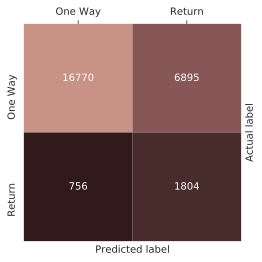

In [26]:
y_n_pred = classifier_log.predict(X_test)
cm = confusion_matrix(y_test, y_n_pred)
sns.heatmap(cm, square=True, annot=True, fmt='.0f', cbar=False, cmap='pink', vmin=0, vmax=4e4);
ax = plt.gca()
ax.xaxis.set_ticks_position('top')
ax.yaxis.set_label_position('right')
plt.ylabel('Actual label');
plt.xticks([0.5,1.5], ['One Way', 'Return']);
plt.xlabel('Predicted label');
plt.yticks([0.5,1.5], ['One Way', 'Return']);

In [27]:
print(classification_report(y_test, y_n_pred,
                            target_names=['One Way', 'Round Trip']))

             precision    recall  f1-score   support

    One Way       0.96      0.71      0.81     23665
 Round Trip       0.21      0.70      0.32      2560

avg / total       0.88      0.71      0.77     26225



Для обоих классов выявлены 70% реальных значений (recall). При этом precision остается очень низким для оборотной поездки, 20%. 
То есть, предсказанный второй класс включил в себя 70% реальных значений, которые составляют на самом деле всего 20% от того, что наш классификатор определил, как возвратную поездку.

При обучении на несбалансированной выборке общая точность повышается до 90%, при этом точность предсказания для оборотных поездок падает до нуля.

Стоит попробовать добиться лучшего баланса между общей точностью предсказания и верным предсказанием оборотных поездок. В качестве метрики будем использовать roc_auc_score, чувствительность модели.

In [28]:
from sklearn.metrics import roc_auc_score

In [29]:
roc_auc_score(y_test, y_n_pred)

0.7066644768117474

### 2.2. Определение оптимальных параметров с помощью кросс-валидации

Будем отыскивать значения параметров методом перебора их значений с кросс-валидацией. Подберем константу регуляризации С. Она отвечает за вклад получаемых регрессией коэффициентов в функцию ошибки. Попытаемся подобрать и лучшие веса классов.

In [30]:
from sklearn.model_selection import GridSearchCV, cross_val_score

Произведем перебор значений параметра, заданных в переменной _param grid_.

In [31]:
param_grid = {'C':[np.e**(i) for i in range(2, 4)],
               'class_weight':[{0:1, 1:(i/10)} for i in range(8, 12)]}
grid_log = GridSearchCV(classifier_log, 
                        param_grid,
                        scoring='roc_auc',
                        verbose=True,
                        n_jobs=-1)
grid_log.fit(df_b_X,
             df_b_y)
print(grid_log.best_params_)
print(grid_log.best_score_)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:   35.1s finished


{'C': 7.3890560989306495, 'class_weight': {0: 1, 1: 1.1}}
0.6842508300017655


Подобранные параметры должны препятсвовать "переучиванию модели".

Проведем оценку работы настроенной модели путем кросс-валидации. 

In [32]:
classifier_log=grid_log.best_estimator_
cvs_log = cross_val_score(classifier_log,
                      df_b_X,
                      df_b_y,
                      scoring='roc_auc',
                      cv = 10,
                      n_jobs=-1)
print(cvs_log.mean())

0.7162582764101696


Чувствительность модели несколько увеличилась за счет лучшего предсказания оборотных поездок (чего мы и добивались). Тем не менее, улучшение составляет всего 1%.

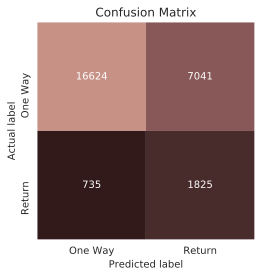

In [33]:
y_n_pred = classifier_log.predict(X_test)
cm = confusion_matrix(y_test, y_n_pred)
sns.heatmap(cm, square=True, annot=True, fmt='.0f', cbar=False, cmap='pink', vmin=0, vmax=4e4)
plt.ylabel('Actual label');
plt.xticks([0.5,1.5], ['One Way', 'Return']);
plt.xlabel('Predicted label');
plt.yticks([0.5,1.5], ['One Way', 'Return']);
plt.title('Confusion Matrix');

### 2.3. Удаление избыточных переменных

В ходе работы с дата-фреймом были сгенерированы дополнительные переменные на базе имеющихся. Связь исходных и сгенерированных переменных может негативно влиять на качество предсказаний модели. Проведем оценку вклада отдельной переменной и удалим избыточные

С помощью класса Permutation Impotance, реализованного в библиотеке eli5, проведем многократную проверку вклада переменной в результирующую точность.

Чтобы реализовать многократную проверку с кросс-валидацией была написана функция PermImp_KFold(df_balanced, K), принимающая на вход выборку и число делений кросс-валидации. Функция возвращает усредненную оценку вклада отельных переменных

In [34]:
import eli5
from sklearn.model_selection import KFold
def PermImp_KFold(df_balanced, K):
    kf = KFold(n_splits=K, shuffle=True, random_state=rs)
    kf.get_n_splits(df_balanced)
    imp = pd.DataFrame(index=df_balanced.columns,
                       columns = ['weight', 'std'])
    imp = imp.replace(np.nan, 0)
    for train_index, test_index in kf.split(df_balanced):
        perm_log = eli5.sklearn.PermutationImportance(classifier_log, scoring='roc_auc')
        perm_log.fit(df_balanced.iloc[test_index, :-1], df_balanced.iloc[test_index, -1])
        test_df = eli5.explain_weights_df(perm_log, feature_names=list(X_train.columns))
        test_df = test_df.set_index('feature')
        imp['weight'] = imp['weight'] + test_df['weight']
        imp['std'] = imp['std'] + test_df['std']
    imp[['weight', 'std']] = imp[['weight', 'std']] / K
    return imp

/home/wswolod/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [35]:
imp = PermImp_KFold(df_pred, 10).sort_values('weight')
imp

,weight,std
Starting Station Longitude,-0.000040,0.000083
Start Day,0.000007,0.000048
Start Month,0.000013,0.000030
Radius,0.000161,0.000150
Starting Station Latitude,0.000181,0.000150
Start Hour,0.000421,0.000478
Staff Annual,0.000563,0.000240
Weekend,0.001106,0.000542
Ratio OI,0.006911,0.001250
Flex Pass,0.008162,0.001231


Переменные в построенной модели имеют небольшой вес, т.е. добавляют не много чувствительности. 

Удалим переменные с вкладом, округляемым до менее 1%. Это позволит улучшить интерпретируемость модели, сделать ее менее вычислительно затратной.

Итак, важными можно считать две группы переменных:
* тип подписки
* характеристики станций по отношениям количества поездок

In [36]:
to_prune = list(imp.index[:8])
print(to_prune)
X_train_pruned = X_train.drop(to_prune, axis=1)
X_test_pruned = X_test.drop(to_prune, axis=1)

['Starting Station Longitude', 'Start Day', 'Start Month', 'Radius', 'Starting Station Latitude', 'Start Hour', 'Staff Annual', 'Weekend']


Протестируем модель обученную на "урезанной" выборке

In [37]:
classifier_log = grid_log.best_estimator_
cvs_log = cross_val_score(classifier_log,
                      df_b_X,
                      df_b_y,
                      scoring='roc_auc',
                      cv = 10,
                      n_jobs=-1)
print(cvs_log.mean())

0.7162582764101696


Удаление переменных практически не отразилось на чувствительности модели.

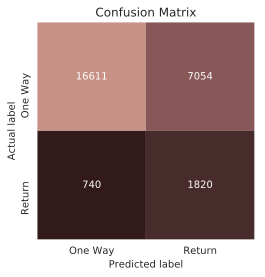

In [38]:
y_n_pred = classifier_log.fit(X_train_pruned, y_train).predict(X_test_pruned)
cm = confusion_matrix(y_test, y_n_pred)
sns.heatmap(cm, square=True, annot=True, fmt='.0f', cbar=False, cmap='pink', vmin=0, vmax=4e4);
plt.ylabel('Actual label');
plt.xticks([0.5,1.5], ['One Way', 'Return']);
plt.xlabel('Predicted label');
plt.yticks([0.5,1.5], ['One Way', 'Return']);
plt.title('Confusion Matrix');

## Часть 3. Интерпретация модели

Для интерпретации модели используем функцию eli5.explain_weights_df(). Она выводит коэффициенты логистической регрессии, которые указывают на изменение отношения шансов для целевой бинарной переменной с единичным изменением значения предиктора. 

In [39]:
eli5.explain_weights_df(classifier_log, feature_names=list(X_test_pruned.columns))

,target,feature,weight
0,1,Ratio Out,3.156936
1,1,Ratio In,2.413700
2,1,<BIAS>,1.015761
3,1,Walk-up,-0.189717
4,1,Ratio OI,-0.347864
5,1,Rush,-0.388799
6,1,Flex Pass,-1.678716
7,1,Monthly Pass,-1.832799


В таблице видим коэффициенты логистической регрессии при предсказании оборотной поездки (target = 1). 

Базовый случай, BIAS - поездка вне часа пик, по подписке работника, со станции с отсутсвием возвратных поездок в истории.

Вероятность совершения оборотной поездки увеличивает:
* повышение доли "исходящих возвратных";
* "входящих возвратных" поездок со станции старта.

Ее же уменьшает:
* час пик;
* повышение общей доли "исходящих" поездок;
* любой тип подписки, но в разной степени;
* walk-up, поездка без подписки так же уменьшает ее, но в меньшей степени, чем подписка.

Это также укладывается в выдвинутое ранее предположение о возвратных поездках как "нерабочих":

* поездка вне часа пик,
* преимущественно без подписки,
* с краевых станций центрального района.

## Результаты

Построена модель на базе логистической регрессии с регуляризацией, предсказывающая оборотную поездку по типу подписки, станции и времени начала поездки c чувствительностью 72%. Предсказание ведется по типу подписки и "балансу" поездок на станции.

__Практические выводы__:

Выявлен сценарий использования сервиса "развеяться на велосипеде в центре города":

* оборотная поездка;
* начало на окраине зоны аренды;
* в нерабочее время: выходные, не час пик;
* без пользования подпиской.

Для таких поездок можно создать отдельный тариф или таргетированную рекламную стратегию для повышения популярности сервиса. 

Построенная модель позволяет предсказывать оборотные поездки для более точного предсказания "баланса" количества велосипедов на станции.

__Замечания__: 

1. Учитывая характер связи между возвращением на исходную станцию и веротяной "целью" поездки, можно предположить, что включение погодных условий в качестве еще одного предиктора поможет повысить точность предсказаний.